In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,  Dense
from tensorflow.keras.models import Model

In [42]:
# 数据加载与预处理
def load_and_preprocess():
    # 读取原始数据
    df_train = pd.read_csv(r"data\train_FD001.txt", sep=' ', header=None)
    df_test = pd.read_csv(r"data\test_FD001.txt", sep=' ', header=None)
    df_RUL = pd.read_csv(r"data\RUL_FD001.txt", header=None)
    
    # 列名定义和清洗
    col_list = ['unit', 'time', 'os_1', 'os_2', 'os_3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 
                'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 
                'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']
    
    df_train = df_train.dropna(axis=1, how='all')
    df_train.columns = col_list
    df_test = df_test.dropna(axis=1, how='all')
    df_test.columns = col_list
    # 筛选有效特征
    new_col_list = ['unit', 'time', 'os_1', 'os_2', 'sm_2', 'sm_3', 'sm_4', 'sm_6', 
                    'sm_7', 'sm_8', 'sm_9', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21'] 
    # 归一化处理
    scale_cols = new_col_list[2:]
    df_train[scale_cols] = minmax_scale(df_train[scale_cols])
    df_test[scale_cols] = minmax_scale(df_test[scale_cols])
    return df_train, df_test, df_RUL

In [43]:
# 构建自编码器模型
def build_autoencoder(input_dim, encoding_dim=3):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)  
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded) 
    autoencoder.compile(optimizer=Adam(0.001), loss='mse')
    return autoencoder, encoder

In [44]:
# 生成健康指标
def generate_health_indicator(train_df, test_df, sensors):
    # 合并数据集用于训练自编码器
    full_data = pd.concat([train_df[sensors], test_df[sensors]], axis=0)  
    # 构建并训练自编码器
    autoencoder, encoder = build_autoencoder(len(sensors), encoding_dim=3)
    autoencoder.fit(full_data, full_data, 
                    epochs=100, 
                    batch_size=32, 
                    shuffle=True,
                    verbose=0)  
    # 生成潜在空间特征
    full_encoded = encoder.predict(full_data) 
    # 使用潜在特征的L2范数作为健康指标
    full_hi = np.linalg.norm(full_encoded, axis=1)  
    # 分割回训练集和测试集
    train_df['HI'] = full_hi[:len(train_df)]
    test_df['HI'] = full_hi[len(train_df):] 
    # 归一化处理
    train_df['HI'] = 1 - minmax_scale(train_df['HI'])
    test_df['HI'] = 1 - minmax_scale(test_df['HI'])   
    # 添加自适应指数平滑
    window_size = 15
    train_df['HI_smooth'] = train_df.groupby('unit')['HI'].transform(
        lambda x: x.ewm(span=window_size, adjust=False).mean()
    )
    test_df['HI_smooth'] = test_df.groupby('unit')['HI'].transform(
        lambda x: x.ewm(span=window_size, adjust=False).mean()
    )
    
    return train_df, test_df

In [45]:
# 可视化健康指标
def visualize_health_indicator(df, engine_id=1, title='Autoencoder Health Indicator Trend'):
    plt.figure(figsize=(12, 6))
    engine_data = df[df['unit'] == engine_id]  
    # 绘制原始HI（半透明细线）
    plt.plot(engine_data['time'], engine_data['HI'], color='gray', alpha=0.3, linewidth=1, linestyle='--')
    # 绘制平滑HI（实线）
    plt.plot(engine_data['time'], engine_data['HI_smooth'], linewidth=2, label=f'Engine {engine_id}')
    plt.title(title + ' (EMA window size=15)')
    plt.xlabel('Operating Cycles')
    plt.ylabel('Health Indicator')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [46]:
def save_hi_to_csv(train_df, test_df, train_file_path="train_HI.csv", test_file_path="test_HI.csv"):
    train_df[['unit', 'time', 'HI', 'HI_smooth']].to_csv(train_file_path, index=False)
    test_df[['unit', 'time', 'HI', 'HI_smooth']].to_csv(test_file_path, index=False)
    print(f"Training HI saved to {train_file_path}")
    print(f"Testing HI saved to {test_file_path}")

1054/1054 [==============================] - 1s 676us/step
Training HI saved to train_HI.csv
Testing HI saved to test_HI.csv


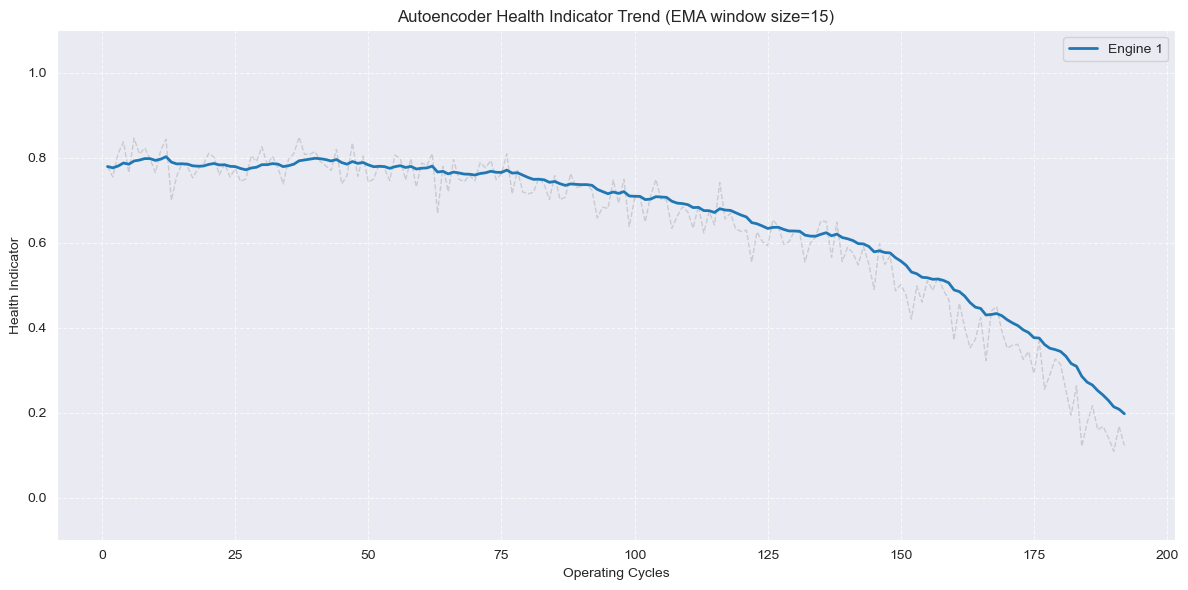

In [48]:
# 加载数据
train_df, test_df, RUL_df = load_and_preprocess()
# 选择传感器
selected_sensors = ['sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_11', 'sm_12', 'sm_13', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
# 生成健康指标
train_df, test_df = generate_health_indicator(train_df, test_df, selected_sensors)
# Save HI to CSV
save_hi_to_csv(train_df, test_df, train_file_path="train_HI.csv", test_file_path="test_HI.csv")
# 可视化示例发动机
visualize_health_indicator(train_df, engine_id=1)